# ScRRAMBLe on MNIST with Data Augmentation
- Using the same pipeline for MNIST, we want to make a quick analysis if data augementation can help in some ways.
- The goal is to potentially go from 97% accuracy to 98%.
- This notebook shold also consist of a dataloader that augments MNIST.

## Data Augementation strategies
- For MNIST, we can't simply apply rotations/flipping as some digits might get messed up e.g. "6" inverted is "9"
- For starters, let's focus on translations and $\leq 10 \degree$ rotations

In [8]:
import jax
import math
import jax.numpy as jnp
import optax
import flax
from flax import nnx
from flax.nnx.nn import initializers
from typing import Callable
import json
import os
import pickle
import numpy as np
from collections import defaultdict
from functools import partial
from tqdm import tqdm
import pandas as pd
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

from utils import clipping_ste, intercore_connectivity, load_mnist_with_validation
from models import ScRRAMBLeLayer


import tensorflow_datasets as tfds  # TFDS to download MNIST.
import tensorflow as tf  # TensorFlow / `tf.data` operations.

In [4]:
# re-using the ScRRAMBLe MNIST model
class ScRRAMBLeMNIST(nnx.Module):
    """
    MNIST Classifier using ScRRAMBLE architecture
    """

    def __init__(
        self,
        input_vector_size: int,
        input_cores: int,
        output_cores: int,
        avg_slot_connectivity: int, 
        slots_per_core: int,
        slot_length: int,
        activation: Callable,
        rngs: nnx.Rngs,
        group_size: int,
        core_length: int = 256,
        threshold: float = 0.0,
        noise_sd: float = 0.05,


    ):

        self.input_vector_size = input_vector_size
        self.input_cores = input_cores
        self.output_cores = output_cores
        self.avg_slot_connectivity = avg_slot_connectivity
        self.slots_per_core = slots_per_core
        self.slot_length = slot_length
        self.rngs = rngs
        self.group_size = group_size
        self.core_length = core_length
        self.threshold = threshold
        self.noise_sd = noise_sd
        self.activation = partial(activation, threshold=threshold, noise_sd=noise_sd, key=rngs.activation())

        # define the scrramble layer
        self.scrramble_layer = ScRRAMBLeLayer(
            input_vector_size=input_vector_size,
            input_cores=input_cores,
            output_cores=output_cores,
            avg_slot_connectivity=avg_slot_connectivity,
            slots_per_core=slots_per_core,
            slot_length=slot_length,
            activation=activation,
            rngs=rngs,
            core_length=core_length,
            threshold=threshold,
            noise_sd=noise_sd
        )

    @staticmethod
    def chunkwise_reshape(x):
        """
        Reshape the input in a block-wise manner similar to how a conv layer would process an image
        Args:
            x: jax.Array, input data (image)
        Returns:
            x: jax.Array, flattened data
        """
        # reshape into 32x32
        x = jax.image.resize(x, (x.shape[0], 32, 32, 1), method='nearest')

        # reshape again
        x = jnp.reshape(x, (x.shape[0], 8, 8, 4, 4, 1))

        # flatten along the last two dimensions
        x = jnp.reshape(x, (x.shape[0], 8, 8, -1))

        # flatten the first two dimensions
        x = jnp.reshape(x, (x.shape[0], -1))

        return x



    @partial(nnx.jit, static_argnames=['output_coding'])
    def __call__(self, x, output_coding: str = 'population'):
        """
        Forward pass for the ScRRAMBLe MNIST classifier
        Args:
            x: jax.Array, input data. Assumed to be flattened MNIST image. No batch.
            output_coding: str, specifies how the binary output should be interpreted. Choices are: ['population', 'svm', ...]. Only 'population' is implemented so far.
        Returns:
            out: jax.Array, output of classifier with population coding applied. (batch_size, group_size)
        """

        # reshape the image
        # print(x.shape)
        # x = jax.image.resize(x, (x.shape[0], 32, 32, 1), method='nearest')
        # x = x.reshape(x.shape[0], -1)

        x = self.chunkwise_reshape(x)

        # using vmap do the forward pass
        y = nnx.vmap(self.scrramble_layer, in_axes=0)(x)

        # check if population coding is used
        if output_coding == 'population':

            # truncation
            y_reshaped = y.reshape(y.shape[0], y.shape[1], -1)
            y_reshaped = y_reshaped[..., :250]

            y_reshaped = y_reshaped.reshape(y_reshaped.shape[0], self.group_size, -1)
            y_reshaped = jnp.mean(y_reshaped, axis=-1)
            
            return y_reshaped
            
        else:
            raise NotImplementedError("Non-population coding not implemented yet.")


    def get_params(self):
        """
        Get the number of parameters in the model
        Naive implementation
        """
        Wi = self.scrramble_layer.Wi.value.flatten()
        Wo = self.scrramble_layer.Wo.value.flatten()
        params = Wi.shape[0] + Wo.shape[0]

        return params

## Data Loading and Augmentation

2025-06-18 18:24:57.662939: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


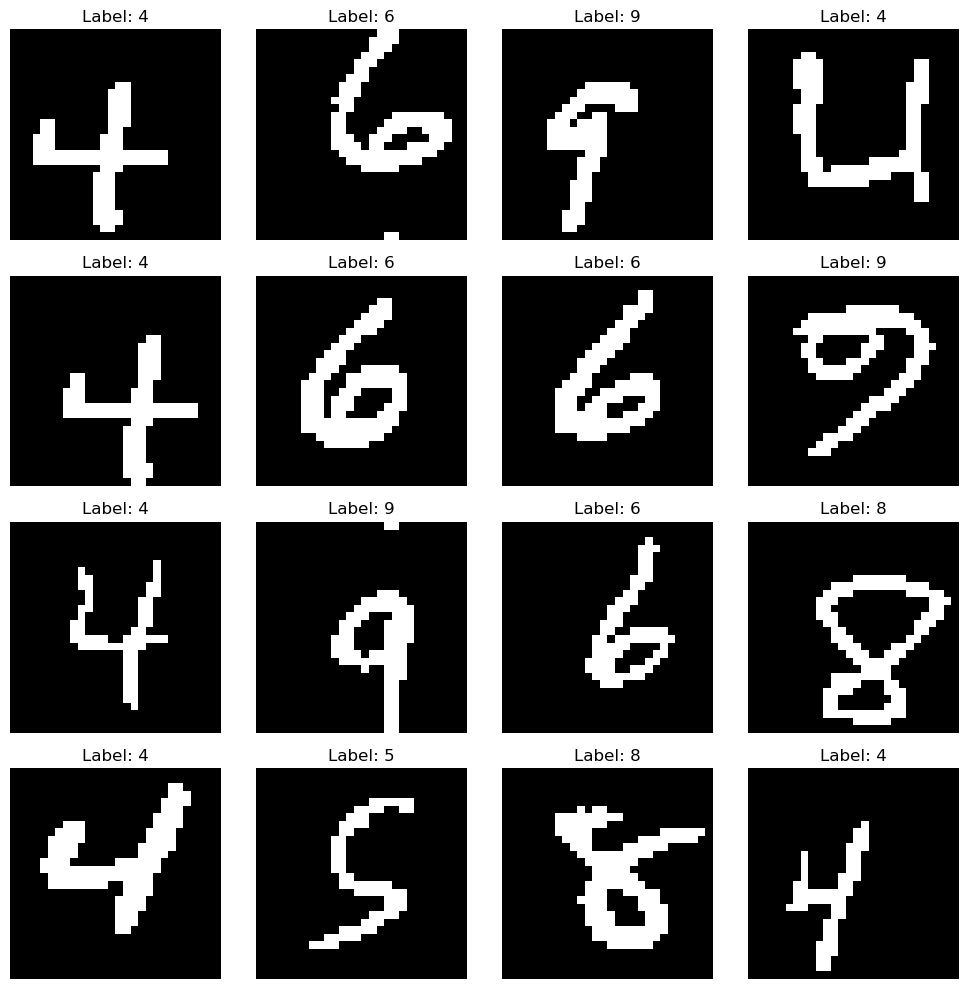

In [10]:
data_dir = "/local_disk/vikrant/datasets"
dataset_dict = {
    'batch_size': 64, # 64 is a good batch size for MNIST
    'train_steps': 20000, # run for longer, 20000 is good!
    'binarize': True, 
    'greyscale': True,
    'data_dir': data_dir,
    'seed': 101,
    'shuffle_buffer': 1024,
    'threshold' : 0.5, # binarization threshold, not to be confused with the threshold in the model
    'eval_every': 500,
}


def load_and_augment_mnist(
    batch_size: int,
    train_steps: int,
    binarize: bool,
    greyscale: bool,
    data_dir: str,
    seed: int,
    shuffle_buffer: int,
    threshold: float, # this is the binarization threshold, not to be confused with the threshold in the model
    augmentation: bool = True,
    aug_translate: bool = True,
    num_translations: int = 4,
    max_shift: int = 3,
    # aug_rotate: float = 10 # degrees
):

    """
    Load and augment the MNIST dataset
    """

    tf.random.set_seed(seed)

    # do train-valid-test split
    train_ds, valid_ds, test_ds = tfds.load('mnist', split=['train[:50000]', 'train[50000:]', 'test'], data_dir=data_dir)

    ## adding helper function

    # normalize
    def _normalize(sample):
        img = tf.cast(sample['image'], tf.float32) / 255.0
        return {'image': img, 'label': sample['label']}

    # translate by a few pixels
    def _translate(image, dx, dy):
        """
        Translate image by dx, dy pixels
        """

        if dx != 0:
            image = tf.roll(image, shift=int(dx), axis=1)
        else:
            pass

        if dy != 0:
            image = tf.roll(image, shift=int(dy), axis=0)
        else:
            pass

        return image
    
    #  a function that puts together the augmented dataset
    def create_augmented_dataset(sample, num_translations=num_translations):

        image = sample['image']
        label = sample['label']

        images = [image]
        labels = [label]

        for _ in range(num_translations):
            # sample dx from a uniform
            dx = tf.random.uniform([], -max_shift, max_shift + 1, dtype=tf.int32)
            dy = tf.random.uniform([], -max_shift, max_shift + 1, dtype=tf.int32)
            translated_image = _translate(image, dx ,dy)
            images.append(translated_image)
            labels.append(label)

        # stack the images
        stacked_images = tf.stack(images)
        stacked_labels = tf.stack(labels)

        aug_dataset = tf.data.Dataset.from_tensor_slices({
            'image': stacked_images,
            'label': stacked_labels
        })

        return aug_dataset

    # check for flags and apply augmentation
    if augmentation:
        train_ds = train_ds.map(create_augmented_dataset).flat_map(lambda x: x)

    # normalize
    def _normalize(sample):
        img = tf.cast(sample['image'], tf.float32) / 255.0
        return {'image': img, 'label': sample['label']}

    train_ds = train_ds.map(_normalize)
    valid_ds = valid_ds.map(_normalize)
    test_ds = test_ds.map(_normalize)

    # apply binarization
    if binarize:
        binarize_mask = lambda s: {
            'image': tf.where(s['image'] > threshold, 1.0, 0.0),
            'label': s['label']
        }

        train_ds = train_ds.map(binarize_mask)
        valid_ds = valid_ds.map(binarize_mask)
        test_ds = test_ds.map(binarize_mask)
    else:
        pass

    # TODO: apply greyscale if more than 3 channels

    # Prepare datasets
    train_ds = train_ds.repeat().shuffle(shuffle_buffer)
    train_ds = train_ds.batch(batch_size, drop_remainder=True).take(train_steps).prefetch(1)
    valid_ds = valid_ds.batch(batch_size, drop_remainder=True).prefetch(1)
    test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

    return train_ds, valid_ds, test_ds


# testing the loading function
train_ds, valid_ds, test_ds = load_and_augment_mnist(
    batch_size=dataset_dict['batch_size'],
    train_steps=dataset_dict['train_steps'],
    binarize=dataset_dict['binarize'],
    greyscale=dataset_dict['greyscale'],
    data_dir=dataset_dict['data_dir'],
    seed=dataset_dict['seed'],
    shuffle_buffer=dataset_dict['shuffle_buffer'],
    threshold=dataset_dict['threshold']
)

# plotting the first batch
batch = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(batch['image'][i].numpy().squeeze(), cmap='gray')
    plt.title(f"Label: {batch['label'][i].numpy()}")
    plt.axis('off')
plt.tight_layout()